In [2]:
%load_ext autoreload
%autoreload 2

import sys
if ".." not in sys.path:
    sys.path.insert(0, "..")

import numpy as np
import cv2
import json
from pathlib import Path
import matplotlib.pyplot as plt
from dataclasses import dataclass

from calib_utils import *

DATA_ROOT = Path("../../data")

In [ ]:
# Load config and map
config_file = Path(DATA_ROOT / "config.json")
with config_file.open() as f:
    config = json.load(f)

map_file = Path(config["map"]["image"])
im_map = imread_rgb(DATA_ROOT / map_file)

T_map_from_world2 = np.array(config["map"]["T_map_from_world2"])
T_world2_from_map = np.linalg.inv(T_map_from_world2)

In [ ]:
# Load constraints
import yaml

constraints_file = Path("camera_constraints.yaml")
with constraints_file.open() as f:
    constraints_data = yaml.safe_load(f)
constraints_data

{'elp_kamera_01': {'camera_position_in_world': [-101.31439363153284,
   54.64604847076174,
   6.0],
  'floor_matches': {'image': [[558, 470],
    [502, 236],
    [769, 245],
    [861, 249],
    [1295, 277],
    [1353, 283],
    [1565, 358],
    [1708, 388],
    [1259, 732],
    [1615, 965]],
   'world': [[-88.52985154, 54.58961867, 0.0],
    [-73.31822199, 55.5207104, 0.0],
    [-75.97108503, 48.97485339, 0.0],
    [-76.62018982, 46.85873582, 0.0],
    [-77.97484329, 35.20598175, 0.0],
    [-78.05950913, 33.14629398, 0.0],
    [-84.04256194, 30.40944859, 0.0],
    [-85.42543735, 25.21790683, 0.0],
    [-94.96445551, 48.94663849, 0.0],
    [-98.85908422, 48.04376166, 0.0]]},
  'floor_polygon': [[628, 1073],
   [430, 741],
   [299, 417],
   [273, 337],
   [498, 236],
   [768, 245],
   [861, 251],
   [1298, 278],
   [1357, 284],
   [1411, 291],
   [1492, 328],
   [1564, 366],
   [1648, 401],
   [1707, 390],
   [1750, 375],
   [1838, 422],
   [1860, 456],
   [1831, 549],
   [1697, 475],
  

zag_elp_cam_019
Number of points in:
  submap corners=None
  floor_polygon=None
  matches_world=None
  matches_image=None
  camera_position_in_world=None


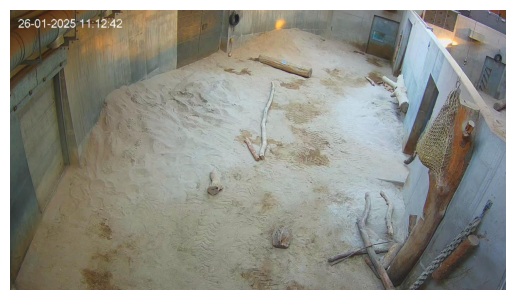

In [ ]:
#######################################
# This is the camera we are calibrating
all_camera_names = [
    "elp_kamera_01",
    "zag_elp_cam_016",
    "zag_elp_cam_017",
    "zag_elp_cam_018",
    "zag_elp_cam_019",
]
camera_name = all_camera_names[4]  # <------CHANGE HERE
print(camera_name)
########################################

submap_corners_in_map = None
floor_polygon_in_camera = None
constraint_points_in_world = None
constraint_points_in_image = None
camera_position_in_world = None

camera_constraints = constraints_data.get(camera_name, None)
if camera_constraints is not None:

    def array_or_none(v):
        return np.array(v) if v is not None else None

    submap_corners_in_map = array_or_none(camera_constraints["submap_corners_in_map"])
    floor_polygon_in_camera = array_or_none(camera_constraints["floor_polygon"])
    constraint_points_in_world = array_or_none(
        camera_constraints["floor_matches"]["world"]
    )
    constraint_points_in_image = array_or_none(
        camera_constraints["floor_matches"]["image"]
    )
    camera_position_in_world = array_or_none(
        camera_constraints["camera_position_in_world"]
    )


def shape_or_none(v):
    return v.shape if v is not None else None


print(f"Number of points in:")
print(f"  submap corners={shape_or_none(submap_corners_in_map)}")
print(f"  floor_polygon={shape_or_none(floor_polygon_in_camera)}")
print(f"  matches_world={shape_or_none(constraint_points_in_world)}")
print(f"  matches_image={shape_or_none(constraint_points_in_image)}")
print(f"  camera_position_in_world={shape_or_none(camera_position_in_world)}")

files = list(DATA_ROOT.glob(f"cameras/{camera_name}/*.jpg"))
assert len(files) > 0, "No image files found in camera dir. Need a sample image."
image_filename = files[0].relative_to(DATA_ROOT)

im_camera = imread_rgb(DATA_ROOT / image_filename)
height, width, _ = im_camera.shape
plt.imshow(im_camera)
plt.gca().set_axis_off()

In [37]:
# Helper class to click on images
class MouseHandler:
    def __init__(self, img: np.ndarray, window_name: str, is_polygon: bool = False):
        self.img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.window_name = window_name
        self.is_polygon = is_polygon
        self.positions = []

    def start(self, window_flags: int = cv2.WINDOW_AUTOSIZE):
        cv2.namedWindow(self.window_name, window_flags)
        cv2.setMouseCallback(self.window_name, self)
        cv2.imshow(self.window_name, self.img)

    def __call__(self, event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            self.positions.append((x, y))
            count = len(self.positions)
            if self.is_polygon:
                color = [0, 0, 200]
            else:
                color = [0, 0, 0]
                color[count % 3] = 200
            self.img = cv2.circle(self.img, (x, y), radius=10, color=color, thickness=5)
            if count > 1 and self.is_polygon:
                prev_x, prev_y = self.positions[count - 2]
                self.img = cv2.line(
                    self.img, (x, y), (prev_x, prev_y), color=color, thickness=3
                )
            cv2.imshow(self.window_name, self.img)

In [ ]:
# Draw floor polygon in camera
# floor_polygon_in_camera = None
if floor_polygon_in_camera is None:
    camera_clicker = MouseHandler(im_camera, f"camera: {camera_name}", is_polygon=True)
    cv2.startWindowThread()
    camera_clicker.start()
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    floor_polygon_in_camera = np.array(camera_clicker.positions)
    print("Floor polygon:")
    display(floor_polygon_in_camera)
else:
    print("Skipping")

Floor polygon:


array([[  22, 1506],
       [ 391,  854],
       [ 915,  344],
       [1176,  247],
       [1791,  208],
       [1923,  243],
       [2059,  283],
       [2122,  772],
       [2117, 1259],
       [1989, 1503],
       [  46, 1509]])

In [ ]:
# Submap corners
# submap_corners_in_map = None
if submap_corners_in_map is None:
    clicker = MouseHandler(im_map, f"map")
    cv2.startWindowThread()
    clicker.start(cv2.WINDOW_NORMAL)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    submap_corners_in_map = np.array(clicker.positions)
    print("submap_corners_in_map:")
    display(submap_corners_in_map)
else:
    print("skipping")

im_submap = im_map[
    submap_corners_in_map[0, 1] : submap_corners_in_map[1, 1],
    submap_corners_in_map[0, 0] : submap_corners_in_map[1, 0],
    :,
]
T_submap_from_map = np.array(
    [
        [1, 0, -submap_corners_in_map[0, 0]],
        [0, 1, -submap_corners_in_map[0, 1]],
        [0, 0, 1],
    ]
)
T_map_from_submap = np.linalg.inv(T_submap_from_map)
T_submap_from_world2 = T_submap_from_map @ T_map_from_world2
T_world2_from_submap = np.linalg.inv(T_submap_from_world2)

submap_corners_in_map:


array([[1343, 1234],
       [2446, 2314]])

In [ ]:
# Click on correspondences between submap and camera
if constraint_points_in_world is None or constraint_points_in_image is None:
    submap_clicker = MouseHandler(im_submap, "submap")
    camera_clicker = MouseHandler(im_camera, f"camera: {camera_name}")

    cv2.startWindowThread()
    submap_clicker.start()
    camera_clicker.start()

    key = cv2.waitKey(0)
    cv2.destroyAllWindows()

    constraint_points_in_image = np.array(camera_clicker.positions)
    constraint_points_in_submap = np.array(submap_clicker.positions)
    constraint_points_in_world2 = hmult(
        T_world2_from_submap, constraint_points_in_submap
    )
    constraint_points_in_world = to_h(constraint_points_in_world2, 0)

    print("World points:")
    display(constraint_points_in_world)
    print("Camera points:")
    display(constraint_points_in_image)
else:
    print("Skipping")

World points:


array([[-53.92974426,  61.8126333 ,   0.        ],
       [-55.48195136,  62.96944424,   0.        ],
       [-66.96828387,  60.96618627,   0.        ],
       [-74.33421209,  50.83703685,   0.        ],
       [-64.6540842 ,  48.38234047,   0.        ],
       [-56.61082924,  58.39863029,   0.        ]])

Camera points:


array([[2061,  279],
       [1927,  241],
       [1174,  251],
       [ 382,  846],
       [2124,  969],
       [2076,  368]])

In [ ]:
# Camera position
# camera_position_in_world  = None
if camera_position_in_world is None:
    submap_clicker = MouseHandler(im_submap, "Select camera position")

    cv2.startWindowThread()
    submap_clicker.start()

    key = cv2.waitKey(0)
    cv2.destroyAllWindows()

    camera_position_in_submap = np.array(submap_clicker.positions).squeeze()
    camera_position_in_world2 = hmult(T_world2_from_submap, camera_position_in_submap)

    FIXED_CAMERA_HEIGHT = 6
    camera_position_in_world = to_h(camera_position_in_world2, FIXED_CAMERA_HEIGHT)

    print("camera_position_in_world:")
    display(camera_position_in_world)
else:
    print("Skipping")

camera_position_in_world:


array([-71.7660149 ,  42.06220267,   6.        ])

In [ ]:
# Save
constraints_data[camera_name] = {
    "submap_corners_in_map": submap_corners_in_map.tolist(),
    "floor_polygon": floor_polygon_in_camera.tolist(),
    "floor_matches": {
        "world": constraint_points_in_world.tolist(),
        "image": constraint_points_in_image.tolist(),
    },
    "camera_position_in_world": camera_position_in_world.tolist(),
}
with constraints_file.open("w") as f:
    yaml.dump(constraints_data, f, default_flow_style=False)
print(f"Updated camera {camera_name} in config {str(constraints_file)}")

Updated camera zag_elp_cam_019 in config camera_constraints.yaml
